<a href="https://colab.research.google.com/github/leeds1219/AI_Notes_and_Projects/blob/main/Single_Shot_Multibox_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practice

In [ ]:
# Requirements
!pip install matplotlib==3.2.1
!pip install numpy==1.14.3
!pip install ConfigArgParse==1.2
!pip install torch==1.5.0
!pip install torchvision==0.6.0
!pip install tqdm==4.45.0

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [2]:
# MXNet Install
!pip install mxnet-cu112

# Check compatibility with your CUDA version
#!nvcc --version

# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive/')  # Mount Google Drive

# Change directory to Colab Notebooks
%cd '/content/drive/MyDrive/Colab Notebooks'

# Clone the GitHub repository
#!git clone https://github.com/MLman/d2l-pytorch.git

# Change directory to the cloned repository
%cd '/content/drive/MyDrive/Colab Notebooks/d2l-pytorch/d2l'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 MB 2.3 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks/d2l-pytorch/d2l


# Single Shot Multibox Detection (SSD)

In the previous few sections, we have introduced bounding boxes, anchor boxes,
multiscale object detection, and data sets. Now, we will use this background
knowledge to construct an object detection model: single shot multibox detection
(SSD) :cite:`Liu.Anguelov.Erhan.ea.2016`. This quick and easy model is already
widely used. Some of the design concepts and implementation details of this
model are also applicable to other object detection models.


## Model

:numref:`fig_ssd` shows the design of an SSD model. The model's main components
are a base network block and several multiscale feature blocks connected in a
series. Here, the base network block is used to extract features of original
images, and it generally takes the form of a deep convolutional neural
network. The paper on SSDs chooses to place a truncated VGG before the
classification layer :cite:`Liu.Anguelov.Erhan.ea.2016`, but this is now
commonly replaced by ResNet. We can design the base network so that it outputs
larger heights and widths. In this way, more anchor boxes are generated based on
this feature map, allowing us to detect smaller objects. Next, each multiscale
feature block reduces the height and width of the feature map provided by the
previous layer (for example, it may reduce the sizes by half). The blocks then
use each element in the feature map to expand the receptive field on the input
image. In this way, the closer a multiscale feature block is to the top of
:numref:`fig_ssd` the smaller its output feature map, and the fewer the anchor
boxes that are generated based on the feature map. In addition, the closer a
feature block is to the top, the larger the receptive field of each element in
the feature map and the better suited it is to detect larger objects. As the SSD
generates different numbers of anchor boxes of different sizes based on the base
network block and each multiscale feature block and then predicts the categories
and offsets (i.e., predicted bounding boxes) of the anchor boxes in order to
detect objects of different sizes, SSD is a multiscale object detection model.

![The SSD is composed of a base network block and several multiscale feature blocks connected in a series. ](../img/ssd.svg)

:label:`fig_ssd`



Next, we will describe the implementation of the modules in :numref:`fig_ssd`. First, we need to discuss the implementation of category prediction and bounding box prediction.

### Category Prediction Layer

Set the number of object categories to $q$. In this case, the number of anchor
box categories is $q+1$, with 0 indicating an anchor box that only contains
background. For a certain scale, set the height and width of the feature map to
$h$ and $w$, respectively. If we use each element as the center to generate $a$
anchor boxes, we need to classify a total of $hwa$ anchor boxes. If we use a
fully connected layer (FCN) for the output, this will likely result in an
excessive number of model parameters. Recall how we used convolutional layer
channels to output category predictions in :numref:`chapter_nin`. SSD uses the
same method to reduce the model complexity.

Specifically, the category prediction layer uses a convolutional layer that
maintains the input height and width. Thus, the output and input have a
one-to-one correspondence to the spatial coordinates along the width and height
of the feature map. Assuming that the output and input have the same spatial
coordinates $(x,y)$, the channel for the coordinates $(x,y)$ on the output
feature map contains the category predictions for all anchor boxes generated
using the input feature map coordinates $(x,y)$ as the center. Therefore, there
are $a(q+1)$ output channels, with the output channels indexed as $i(q+1) + j$
($0 \leq j \leq q$) representing the predictions of the category index $j$ for
the anchor box index $i$.

Now, we will define a category prediction layer of this type. After we specify
the parameters $a$ and $q$, it uses a $3\times3$ convolutional layer with a
padding of 1. The heights and widths of the input and output of this
convolutional layer remain unchanged.

In [3]:
!pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
 

In [4]:
%matplotlib inline
import sys
sys.path.insert(0, '..')
import d2l
# from d2l.ssd_utils import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import json
import time
from tqdm import tqdm
from PIL import Image
def cls_predictor(input_channels, num_anchors, num_classes):
    return nn.Conv2d(in_channels=input_channels, out_channels=num_anchors * (num_classes + 1), kernel_size=3,
                     padding=1)

### Bounding Box Prediction Layer

The design of the bounding box prediction layer is similar to that of the category prediction layer. The only difference is that, here, we need to predict 4 offsets for each anchor box, rather than $q+1$ categories.

In [5]:
def bbox_predictor(input_channels, num_anchors):
    return nn.Conv2d(in_channels=input_channels, out_channels=num_anchors * 4, kernel_size=3, padding=1)

### Concatenating Predictions for Multiple Scales

As we mentioned, SSD uses feature maps based on multiple scales to generate anchor boxes and predict their categories and offsets. Because the shapes and number of anchor boxes centered on the same element differ for the feature maps of different scales, the prediction outputs at different scales may have different shapes.

In the following example, we use the same batch of data to construct feature maps of two different scales, `Y1` and `Y2`. Here, `Y2` has half the height and half the width of `Y1`. Using category prediction as an example, we assume that each element in the `Y1` and `Y2` feature maps generates five (Y1) or three (Y2) anchor boxes. When there are 10 object categories, the number of category prediction output channels is either $5\times(10+1)=55$ or $3\times(10+1)=33$. The format of the prediction output is (batch size, number of channels, height, width). As you can see, except for the batch size, the sizes of the other dimensions are different. Therefore, we must transform them into a consistent format and concatenate the predictions of the multiple scales to facilitate subsequent computation.

In [6]:
def forward(x, block):
    return block(x)
Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
(Y1.shape, Y2.shape)

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

The channel dimension contains the predictions for all anchor boxes with the same center. We first move the channel dimension to the final dimension. Because the batch size is the same for all scales, we can convert the prediction results to binary format (batch size, height $\times$ width $\times$ number of channels) to facilitate subsequent concatenation on the 1st dimension.

In [7]:
def flatten_pred(pred):
    return pred.permute(0, 2, 3, 1).reshape(pred.size(0),-1)

def concat_preds(preds):
    return torch.cat(tuple([flatten_pred(p) for p in preds]), dim=1)

Thus, regardless of the different shapes of `Y1` and `Y2`, we can still concatenate the prediction results for the two different scales of the same batch.

In [8]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

### Height and Width Downsample Block

For multiscale object detection, we define the following `down_sample_blk` block, which reduces the height and width by 50%. This block consists of two $3\times3$ convolutional layers with a padding of 1 and a $2\times2$ maximum pooling layer with a stride of 2 connected in a series. As we know, $3\times3$ convolutional layers with a padding of 1 do not change the shape of feature maps. However, the subsequent pooling layer directly reduces the size of the feature map by half. Because $1\times 2+(3-1)+(3-1)=6$, each element in the output feature map has a receptive field on the input feature map of the shape $6\times6$. As you can see, the height and width downsample block enlarges the receptive field of each element in the output feature map.

In [9]:
def down_sample_blk(input_channels, num_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels=input_channels, out_channels=num_channels, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(num_features=num_channels))
        blk.append(nn.ReLU())
        input_channels=num_channels
    blk.append(nn.MaxPool2d(kernel_size=2, stride=2))
    blk = nn.Sequential(*blk)
    return blk

By testing forward computation in the height and width downsample block, we can see that it changes the number of input channels and halves the height and width.

In [10]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

### Base Network Block

The base network block is used to extract features from original images. To simplify the computation, we will construct a small base network. This network consists of three height and width downsample blocks connected in a series, so it doubles the number of channels at each step. When we input an original image with the shape $256\times256$, the base network block outputs a feature map with the shape $32 \times 32$.

In [11]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    blk = nn.Sequential(*blk)
    return blk

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

### The Complete Model

The SSD model contains a total of five modules. Each module outputs a feature
map used to generate anchor boxes and predict the categories and offsets of
these anchor boxes. The first module is the base network block, modules two to
four are height and width downsample blocks, and the fifth module is a global
maximum pooling layer that reduces the height and width to 1. Therefore, modules
two to five are all multiscale feature blocks shown in :numref:`fig_ssd`.

In [12]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)

    return blk

Now, we will define the forward computation process for each module. In contrast to the previously-described convolutional neural networks, this module not only returns feature map `Y` output by convolutional computation, but also the anchor boxes of the current scale generated from `Y` and their predicted categories and offsets.

In [13]:
import itertools
import math
def create_anchors(feature_map_sizes, steps, sizes):
    """Compute default box sizes with scale and aspect transform."""
    scale = 256.
    steps = [s / scale for s in steps]
    sizes = [s / scale for s in sizes]

    aspect_ratios = ((2,),)


    num_layers = len(feature_map_sizes)

    boxes = []
    for i in range(num_layers):
        fmsize = feature_map_sizes[i]
        for h, w in itertools.product(range(fmsize), repeat=2):
            cx = (w + 0.5)*steps[i]
            cy = (h + 0.5)*steps[i]
            s = sizes[i]
            boxes.append((cx, cy, s, s))

            s = sizes[i+1]
            boxes.append((cx, cy, s, s))

            s = sizes[i]
            for ar in aspect_ratios[i]:

#                 boxes.append((cx - (s * math.sqrt(ar))/2, cy - (s / math.sqrt(ar))/2, cx + (s * math.sqrt(ar))/2, cy + (s / math.sqrt(ar))/2))
#                 boxes.append((cx - (s / math.sqrt(ar))/2, cy - (s * math.sqrt(ar))/2, cx + (s / math.sqrt(ar))/2, cy + (s * math.sqrt(ar))/2))

                boxes.append((cx, cy, (s * math.sqrt(ar)), (s / math.sqrt(ar))))
                boxes.append((cx, cy, (s / math.sqrt(ar)), (s * math.sqrt(ar))))

    return torch.Tensor(boxes) # [8632, 4]

In [17]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = create_anchors((Y.size(2),), (256/Y.size(2),), size)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

As we mentioned, the closer a multiscale feature block is to the top in :numref:`fig_ssd`, the larger the objects it detects and the larger the anchor boxes it must generate. Here, we first divide the interval from 0.2 to 1.05 into five equal parts to determine the sizes of smaller anchor boxes at different scales: 0.2, 0.37, 0.54, etc. Then, according to $\sqrt{0.2 \times 0.37} = 0.272$, $\sqrt{0.37 \times 0.54} = 0.447$, and similar formulas, we determine the sizes of larger anchor boxes at the different scales.

In [14]:
sizes = [[0.2*256, 0.272*256], [0.37*256, 0.447*256], [0.54*256, 0.619*256],
         [0.71*256, 0.79*256], [0.88*256, 0.961*256]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

Now, we can define the complete model, `TinySSD`.

In [15]:
class TinySSD(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(TinySSD, self).__init__()

        input_channels_cls = 128
        input_channels_bbox = 128
        self.num_classes = num_classes

        self.blk = []
        self.cls = []
        self.bbox = []

        self.blk_0 = get_blk(0)
        self.blk_1 = get_blk(1)
        self.blk_2 = get_blk(2)
        self.blk_3 = get_blk(3)
        self.blk_4 = get_blk(4)

        self.cls_0 = cls_predictor(64, num_anchors, num_classes)
        self.cls_1 = cls_predictor(input_channels_cls, num_anchors, num_classes)
        self.cls_2 = cls_predictor(input_channels_cls, num_anchors, num_classes)
        self.cls_3 = cls_predictor(input_channels_cls, num_anchors, num_classes)
        self.cls_4 = cls_predictor(input_channels_cls, num_anchors, num_classes)

        self.bbox_0 = bbox_predictor(64, num_anchors)
        self.bbox_1 = bbox_predictor(input_channels_bbox, num_anchors)
        self.bbox_2 = bbox_predictor(input_channels_bbox, num_anchors)
        self.bbox_3 = bbox_predictor(input_channels_bbox, num_anchors)
        self.bbox_4 = bbox_predictor(input_channels_bbox, num_anchors)

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5

        X, anchors[0], cls_preds[0], bbox_preds[0] = blk_forward(X, self.blk_0, sizes[0], ratios[0],
                                                                    self.cls_0, self.bbox_0)

        X, anchors[1], cls_preds[1], bbox_preds[1] = blk_forward(X, self.blk_1, sizes[1], ratios[1],
                                                                    self.cls_1, self.bbox_1)

        X, anchors[2], cls_preds[2], bbox_preds[2] = blk_forward(X, self.blk_2, sizes[2], ratios[2],
                                                                    self.cls_2, self.bbox_2)

        X, anchors[3], cls_preds[3], bbox_preds[3] = blk_forward(X, self.blk_3, sizes[3], ratios[3],
                                                                    self.cls_3, self.bbox_3)

        X, anchors[4], cls_preds[4], bbox_preds[4] = blk_forward(X, self.blk_4, sizes[4], ratios[4],
                                                                    self.cls_4, self.bbox_4)

        return (torch.cat(anchors, dim=0), concat_preds(cls_preds).reshape((-1, 5444, self.num_classes + 1)),
                concat_preds(bbox_preds))

In [18]:
anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5

We now create an SSD model instance and use it to perform forward computation on image mini-batch `X`, which has a height and width of 256 pixels. As we verified previously, the first module outputs a feature map with the shape $32 \times 32$. Because modules two to four are height and width downsample blocks, module five is a global pooling layer, and each element in the feature map is used as the center for 4 anchor boxes, a total of $(32^2 + 16^2 + 8^2 + 4^2 + 1)\times 4 = 5444$ anchor boxes are generated for each image at the five scales.

In [19]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

net = TinySSD(3, num_classes=1)
net.apply(init_weights)

X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


## Training

Now, we will explain, step by step, how to train the SSD model for object detection.

### Data Reading and Initialization

We read the Pikachu data set we created in the previous section.

For this part you need mxnet library to download and convert the mxnet's .rec file to png images and they will be saved in the 'data' directory.

In [20]:
d2l.download_and_preprocess_data()

**Error num_workers**

In [21]:
batch_size = 32
data_dir = '../data/pikachu/'
train_dataset = d2l.PIKACHU(data_dir, 'train')
val_dataset = d2l.PIKACHU(data_dir, 'val')

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=4) # original 4

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size, shuffle=False,
                                         num_workers=4) # original 4

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


There is 1 category in the Pikachu data set. After defining the module, we need to initialize the model parameters and define the optimization algorithm.

In [ ]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '7' # You can set gpu no. if you have multiple gpus

In [22]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:0


In [23]:
net = TinySSD(3, num_classes=1)
net.apply(init_weights)
net = net.to(device)

learning_rate = 1e-3
weight_decay = 5e-4
optimizer = optim.SGD(net.parameters(), lr = learning_rate, weight_decay=weight_decay)

### Define Loss and Evaluation Functions

Object detection is subject to two types of losses. The first is anchor box category loss. For this, we can simply reuse the cross-entropy loss function we used in image classification. The second loss is positive anchor box offset loss. Offset prediction is a normalization problem. However, here, we do not use the squared loss introduced previously. Rather, we use the $L_1$ norm loss, which is the absolute value of the difference between the predicted value and the ground-truth value.Then we remove the negative anchor boxes and padding anchor boxes from the loss calculation. Finally, we add the anchor box category and offset losses to find the final loss function for the model.

We can use the accuracy rate to evaluate the classification results. As we use the $L_1$ norm loss, we will use the average absolute error to evaluate the bounding box prediction results.

In [24]:
id_cat = dict()
id_cat[0] = 'pikachu'

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, device="cuda:0", eps=1e-10):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.device = device
        self.eps = eps

    def forward(self, input, target):
        p = torch.sigmoid(input)
        pt = p * target.float() + (1.0 - p) * (1 - target).float()
        alpha_t = (1.0 - self.alpha) * target.float() + self.alpha * (1 - target).float()
        loss = - 1.0 * torch.pow((1 - pt), self.gamma) * torch.log(pt + self.eps)
        return loss.sum()

class SSDLoss(nn.Module):
    def __init__(self, loc_factor, jaccard_overlap, device = "cuda:0", **kwargs):
        super().__init__()
        self.fl = FocalLoss(**kwargs)
        self.loc_factor = loc_factor
        self.jaccard_overlap = jaccard_overlap



        self.device = device

    def one_hot_encoding(labels, num_classes):
        return torch.eye(num_classes)[labels]

    def loc_transformation(x, anchors, overlap_indicies):
        # Doing location transformations according to SSD paper
        return torch.cat([(x[:, 0:1] - anchors[overlap_indicies, 0:1]) / anchors[overlap_indicies, 2:3],
                          (x[:, 1:2] - anchors[overlap_indicies, 1:2]) / anchors[overlap_indicies, 3:4],
                          torch.log((x[:, 2:3] / anchors[overlap_indicies, 2:3])),
                          torch.log((x[:, 3:4] / anchors[overlap_indicies, 3:4]))
                         ], dim=1)

    def forward(self, class_hat, bb_hat, class_true, bb_true, anchors):
        loc_loss = 0.0
        class_loss = 0.0


        for i in range(len(class_true)):  # Batch level

            class_hat_i = class_hat[i, :, :]

            bb_true_i = bb_true[i].float()

            class_true_i = class_true[i]

            class_target = torch.zeros(class_hat_i.shape[0]).long().to(self.device)

            overlap_list = d2l.find_overlap(bb_true_i.squeeze(0), anchors, self.jaccard_overlap)

            temp_loc_loss = 0.0
            for j in range(len(overlap_list)):  # BB level
                overlap = overlap_list[j]
                class_target[overlap] = class_true_i[0, j].long()

                input_ = bb_hat[i, overlap, :]
                target_ = SSDLoss.loc_transformation(bb_true_i[0, j, :].expand((len(overlap), 4)), anchors, overlap)

                temp_loc_loss += F.smooth_l1_loss(input=input_, target=target_, reduction="sum") / len(overlap)
            loc_loss += temp_loc_loss / class_true_i.shape[1]

            class_target = SSDLoss.one_hot_encoding(class_target, len(id_cat) + 1).float().to(self.device)
            class_loss += self.fl(class_hat_i, class_target) / class_true_i.shape[1]

        loc_loss = loc_loss / len(class_true)
        class_loss = class_loss / len(class_true)
        loss = class_loss + loc_loss * self.loc_factor

        return loss, loc_loss, class_loss

### Train the Model

During model training, we must generate multiscale anchor boxes (`anchors`) in the model's forward computation process and predict the category (`cls_preds`) and offset (`bbox_preds`) for each anchor box.  Finally, we calculate the loss function using the predicted and labeled category and offset values. To simplify the code, we do not evaluate the training data set here.

In [25]:
loss = SSDLoss(loc_factor=5.0, jaccard_overlap=0.5, device="cuda:0")

RuntimeError: ignored

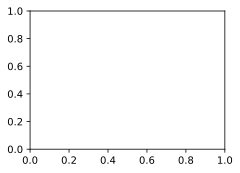

In [26]:
num_epochs = 25
init_epoch = 0

# Uncomment the following 2 lines if you wish to load a pre-trained/saved model
# checkpoint_path = './ssd_outputs/model-29_0.1411931432526687.pth'   # Mention the model name to load
# init_epoch = d2l.load(net, checkpoint_path, optimizer)

animator = d2l.Animator(xlabel='epoch', xlim=[init_epoch+1, num_epochs],
                        legend=['class error', 'bbox mae', 'train_err'])

for epoch in range(init_epoch, num_epochs):

    net.train()

    train_loss = 0.0
    loc_loss = 0.0
    class_loss = 0.0

    for i, (x, bb_true, class_true) in (enumerate(train_loader)):

        x = x.to(device)
        bb_true = bb_true.to(device)
        class_true = class_true.to(device)

        timer_start = time.time()

        anchors, cls_preds, bbox_preds = net(x)

        class_true = [*class_true.reshape((class_true.size(0), 1, 1))]
        bb_true = [*bb_true.reshape((bb_true.size(0), 1, 1, 4))]

        bbox_preds = bbox_preds.reshape((-1, 5444, 4))

        # Label the category and offset of each anchor box

        anchors = anchors.to(device)

        batch_loss, batch_loc_loss, batch_class_loss = loss(cls_preds, bbox_preds, class_true, bb_true, anchors)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        class_loss += batch_class_loss
        loc_loss += batch_loc_loss
        train_loss += batch_loss

#     Uncomment the following 2 line for saving the model every epoch
#     path_to_checkpoints_dir = './ssd_outputs/'
#     d2l.save(net, path_to_checkpoints_dir, epoch, optimizer, train_loss/len(train_loader))

    train_loss = (train_loss/len(train_loader)).detach().cpu().numpy()
    loc_loss = (loc_loss/len(train_loader)).detach().cpu().numpy()
    class_loss = (class_loss/len(train_loader)).detach().cpu().numpy()

#     print(class_loss, loc_loss, train_loss, epoch+1)

    # Uncomment the following if you wish to see the results after every epoch to see the learning effect
    # Images will be saved to the 'results_every_epoch' directory

#     try:
#         d2l.infer(net, epoch, 0.9, device)
#     except Exception as e:
#         print(e, 'error' + str(epoch+1))


    animator.add(epoch, (class_loss, loc_loss, train_loss))

### Saving the final Model

In [ ]:
path_to_checkpoints_dir = './ssd_outputs'
d2l.save(net, path_to_checkpoints_dir, epoch, optimizer, train_loss/len(train_loader))

## Prediction

In the prediction stage, we want to detect all objects of interest in the image. Below, we read the test image and transform its size. Then, we convert it to the four-dimensional format required by the convolutional layer.

In [27]:
img = np.array(Image.open('../img/pikachu.jpg').convert('RGB').resize((256, 256), Image.BILINEAR))
X = transforms.Compose([transforms.ToTensor()])(img).to(device)
X = X.to(device)

We predict the bounding boxes based on the anchor boxes and their predicted offsets. Then, we use non-maximum suppression to remove similar bounding boxes.

In [28]:
def predict(X, nms_threshold):
    background_threshold = 0.8
    net.eval()
    anchors, class_hat, bb_hat = net(X.unsqueeze(0))
    anchors = anchors.to(device)
    bb_hat = bb_hat.reshape((1, -1, 4))
    bb_hat = d2l.invert_transformation(bb_hat.squeeze(0), anchors)
    bb_hat = bb_hat * 256.0

    class_hat = class_hat.sigmoid().squeeze(0)

    bb_hat = bb_hat[class_hat[:,0] < background_threshold, :]


    bb_hat = bb_hat.detach().cpu().numpy()
    class_hat = class_hat[class_hat[:,0] < background_threshold, :]

    class_preds = class_hat[:, 1:]

    prob, class_id = torch.max(class_preds,1)

    prob = prob.detach().cpu().numpy()
    class_id = class_id.detach().cpu().numpy()



    output_bb = [d2l.PredBoundingBox(probability=1 - prob[i],
                                 class_id=class_id[i],
                                 classname=id_cat[class_id[i]],
                                 bounding_box=[bb_hat[i, 0],
                                               bb_hat[i, 1],
                                               bb_hat[i, 2],
                                               bb_hat[i, 3]])
                                 for i in range(0, len(prob))]

    output_bb = sorted(output_bb, key = lambda x: x.probability, reverse=False)

    filtered_bb = d2l.non_max_suppression(output_bb, nms_threshold)

    return filtered_bb

filtered_bb = predict(X, 0.1)

Finally, we take all the bounding boxes and display them as the final output.

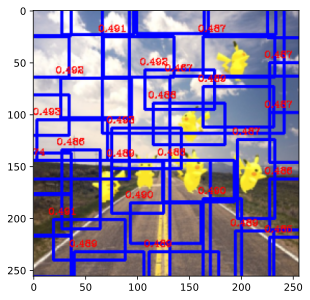

In [29]:
def display(img, output):

    img = d2l.draw_boxes(img, [bb.bounding_box for bb in filtered_bb])
    img = d2l.draw_text(img, [str(bb.probability)[:5] for bb in filtered_bb], [bb.bounding_box for bb in filtered_bb])
    d2l.plt.imshow(img)
    d2l.plt.show()

display(img, filtered_bb)

## Summary

* SSD is a multiscale object detection model. This model generates different numbers of anchor boxes of different sizes based on the base network block and each multiscale feature block and predicts the categories and offsets of the anchor boxes to detect objects of different sizes.
* During SSD model training, the loss function is calculated using the predicted and labeled category and offset values.



## Exercises

* Due to space limitations, we have ignored some of the implementation details of SSD models in this experiment. Can you further improve the model in the following areas?


### Loss Function

For the predicted offsets, replace $L_1$ norm loss with $L_1$ regularization loss. This loss function uses a square function around zero for greater smoothness. This is the regularized area controlled by the hyper-parameter $\sigma$:

$$
f(x) =
    \begin{cases}
    (\sigma x)^2/2,& \text{if }|x| < 1/\sigma^2\\
    |x|-0.5/\sigma^2,& \text{otherwise}
    \end{cases}
$$

When $\sigma$ is large, this loss is similar to the $L_1$ norm loss. When the value is small, the loss function is smoother.

In [30]:
sigmas = [10, 1, 0.5]
lines = ['-', '--', '-.']
x = np.arange(-2, 2, 0.1)
d2l.set_figsize()

In [31]:
def smooth_l1(x, scalar):
    a = []
    for i in x:

        if abs(i) < 1/((scalar)**2):
            a.append(((scalar*i)**2)/2)

        else:
            a.append(abs(i) - 0.5/((scalar)**2))

    return np.array(a)


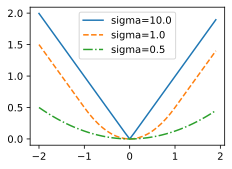

In [32]:
a1 = []
for l, s in zip(lines, sigmas):
    y = smooth_l1(x, scalar=s)
    d2l.plt.plot(x, y, l, label='sigma=%.1f' % s)

d2l.plt.legend();

In the experiment, we used cross-entropy loss for category prediction. Now,
assume that the prediction probability of the actual category $j$ is $p_j$ and
the cross-entropy loss is $-\log p_j$. We can also use the focal loss
:cite:`Lin.Goyal.Girshick.ea.2017`. Given the positive hyper-parameters $\gamma$
and $\alpha$, this loss is defined as:

$$ - \alpha (1-p_j)^{\gamma} \log p_j.$$

As you can see, by increasing $\gamma$, we can effectively reduce the loss when the probability of predicting the correct category is high.

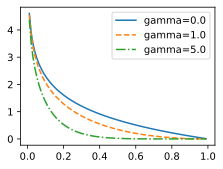

In [33]:
def focal_loss(gamma, x):
    return -(1 - x) ** gamma * np.log(x)

x = np.arange(0.01, 1, 0.01)

for l, gamma in zip(lines, [0, 1, 5]):
    y = d2l.plt.plot(x, focal_loss(gamma, x), l,
                     label='gamma=%.1f' % gamma)

d2l.plt.legend();

### Training and Prediction

* When an object is relatively large compared to the image, the model normally adopts a larger input image size.
* This generally produces a large number of negative anchor boxes when labeling anchor box categories. We can sample the negative anchor boxes to better balance the data categories.
* Assign hyper-parameters with different weights to the anchor box category loss and positive anchor box offset loss in the loss function.
* Refer to the SSD paper. What methods can be used to evaluate the precision of
  object detection models :cite:`Liu.Anguelov.Erhan.ea.2016`?